# Trilogy color images

[CEERS SDR3](https://ceers.github.io/sdr3.html) Simulated Data Release 3 NIRCam images in 6 filters:  
https://ceers.github.io/sdr3.html

[Trilogy](https://www.stsci.edu/~dcoe/trilogy/Intro.html) adapted for use in a Python 3 Jupyter notebook

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import join
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, LinearStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats

from importlib import reload

In [2]:
#%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm

In [9]:
# Trilogy

from scipy.optimize import golden

def da(k):
    a1 = k * (x1 - x0) + 1
    a2 = k * (x2 - x0) + 1
    a1n = a1**n
    a1n = np.abs(a1n)  # Don't want the solutions where a1 & a2 are both negative!
    da1 = a1n - a2
    k = np.abs(k)
    if k == 0:
        return da(1e-10)
    else:
        da1 = da1 / k  # To avoid solution k = 0!
    return abs(da1)

def imscale2(data, levels, y1):
    # x0, x1, x2  YIELD  0, y1, 1,  RESPECTIVELY
    # y1 = noiselum
    global n, x0, x1, x2  # So that golden can use them
    x0, x1, x2 = levels  
    if y1 == 0.5:
        k = (x2 - 2 * x1 + x0) / float(x1 - x0) ** 2
    else:
        n = 1 / y1
        k = np.abs(golden(da))
    r1 = np.log10( k * (x2 - x0) + 1)
    v = np.ravel(data)
    v = clip2(v, 0, None)
    d = k * (v - x0) + 1
    d = clip2(d, 1e-30, None)
    z = np.log10(d) / r1
    z = np.clip(z, 0, 1)
    z.shape = data.shape
    z = z * 255
    z = z.astype(np.uint8)
    return z

def clip2(m, m_min=None, m_max=None):
    if m_min == None:
        m_min = np.min(m)
    if m_max == None:
        m_max = np.max(m)
    return np.clip(m, m_min, m_max)


# PREVIOUSLY in colorimage.py
def set_levels(data, pp, stripneg=False, sortedalready=False):
    if sortedalready:
        vs = data
    else:
        print('sorting...')
        vs = np.sort(data.flat)
    if stripneg:  # Get rid of negative values altogether!
        # This is the way I was doing it for a while
        # Now that I'm not, resulting images should change (get lighter)
        i = np.searchsorted(vs, 0)
        vs = vs[i+1:]
    else:  # Clip negative values to zero
        vs = clip2(vs, 0, None)
    ii = np.array(pp) * len(vs)
    ii = ii.astype(int)
    ii = np.clip(ii, 0, len(vs)-1)
    levels = vs.take(ii)
    #print ii, levels, vs, sort(vs)
    return levels


def determine_scaling(data, unsatpercent, noisesig=1, correctbias=True, noisesig0=2):
    """Determines data values (x0,x1,x2) which will be scaled to (0,noiselum,1)"""
    # Robust mean & standard deviation
    datasorted = data + 0
    datasorted[np.isnan(datasorted)]=0  # set all nan values to zero
    datasorted = np.sort(datasorted.flat)
    if datasorted[0] == datasorted[-1]:  # data is all one value
        levels = 0, 1, 100  # whatever
    else:
        data_mean, data_median, data_stddev = sigma_clipped_stats(datasorted)
        m = data_mean
        r = data_stddev
        print('%g +/- %g' % (m, r))

        if correctbias:
            x0 = m - noisesig0 * r
        else:
            x0 = 0
        x1 = m + noisesig * r
        x2 = set_levels(datasorted, np.array([unsatpercent]), sortedalready=True)[0]
        levels = x0, x1, x2
    return levels

def stamp_extent(data, sample_size=1000, dx=0, dy=0):
    data_shape = data.shape
    if len(data_shape) == 2:
        ny, nx = data.shape
    else:
        ny, nx, three = data.shape
    
    yc = int(ny / 2)
    xc = int(nx / 2)
    #print(xc, yc)
    #print(xc+dx, yc+dy)
    
    ylo = yc - sample_size / 2 + dy
    yhi = yc + sample_size / 2 + dy

    xlo = xc - sample_size / 2 + dx
    xhi = xc + sample_size / 2 + dx
    #print(xlo, xhi, ylo, yhi)
    
    ylo = int(np.clip(ylo, 0, ny))
    yhi = int(np.clip(yhi, 0, ny))
    xlo = int(np.clip(xlo, 0, nx))
    xhi = int(np.clip(xhi, 0, nx))
    #print(xlo, xhi, ylo, yhi)
    return xlo, xhi, ylo, yhi

def image_stamps(data, sample_size=1000, dx=0, dy=0):
    xlo, xhi, ylo, yhi = stamp_extent(data, sample_size, dx, dy)
    stamps = data[ylo:yhi,xlo:xhi]
    return stamps

image_stamp = image_stamps

# Start here

In [4]:
#image_files_list = glob('../images/*.fits')
#image_files_list = list(np.sort(image_files_list))

field = 'ceers5'  # insert target name here
filters = 'F115W F150W F200W F277W F356W F444W'.split()
image_files_list = ['../images/%s_%s_sci.fits.gz' % (field, filt.lower()) for filt in filters]

image_files_dict = {}
for i, filt in enumerate(filters):
    image_files_dict[filt] = image_files_list[i]
    print(filt, image_files_dict[filt])
    
idata = 1  # index where science data is

F115W ../images/ceers5_f115w_sci.fits.gz
F150W ../images/ceers5_f150w_sci.fits.gz
F200W ../images/ceers5_f200w_sci.fits.gz
F277W ../images/ceers5_f277w_sci.fits.gz
F356W ../images/ceers5_f356w_sci.fits.gz
F444W ../images/ceers5_f444w_sci.fits.gz


# View images (optional)

<IPython.core.display.Javascript object>


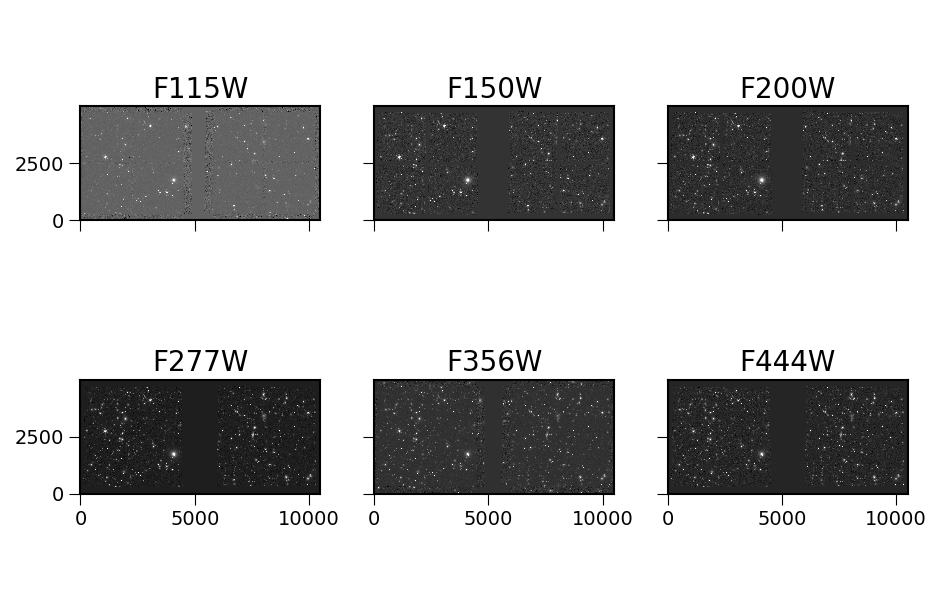

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(9.5,6), sharex=True, sharey=True)

for i, filt in enumerate(filters):
    iy = i // 3
    ix = i % 3
    hdu = pyfits.open(image_files_list[i])
    data = hdu[idata].data
    norm = simple_norm(data, 'sqrt', min_percent=0.1, max_percent=99.9)
    ax[iy,ix].imshow(data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r')
    ax[iy,ix].set_title(filt)

# Sample a region of the image and make a color stamp

## Iterate until it looks good

In [7]:
# Input parameters

#noiselum = 0.25
#satpercent = 0.03
noiselum = 0.10
satpercent = 0.01
unsatpercent = 1 - 0.01 * satpercent

sample_size = 1000
dx = -2500
dy =  1000

noisesig = 1
correctbias = True
noisesig0 = 2

<IPython.core.display.Javascript object>


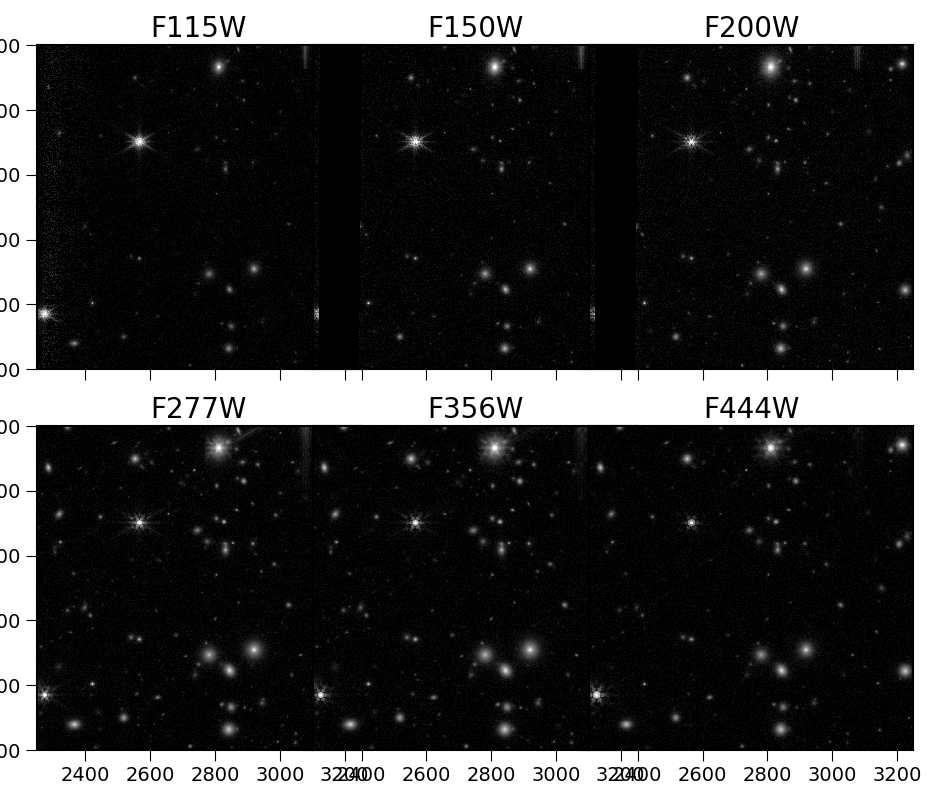

0.00119261 +/- 0.00869342
0.000801233 +/- 0.00681117
0.00109194 +/- 0.00566735
0.000754148 +/- 0.00336788
0.000710496 +/- 0.00301955
0.000942347 +/- 0.00473236


In [10]:
nrows = 2
ncolumns = int(len(filters) / nrows)
fig, ax = plt.subplots(nrows, ncolumns, figsize=(9.5,8), sharex=True, sharey=True)

scaled_images = {}
levels_all = {}
my_stamp_extent = stamp_extent(data, sample_size, dx, dy)
for i, filt in enumerate(filters):
    data = fits.open(image_files_list[i])[idata].data
    stamp = image_stamp(data, sample_size, dx, dy)
    levels = determine_scaling(stamp.ravel(), unsatpercent, noisesig, correctbias, noisesig0)
    scaled = imscale2(stamp, levels, noiselum)
    levels_all[filt] = levels
    scaled_images[filt] = scaled
    ix = i % ncolumns
    iy = int(i / ncolumns)
    ax[iy,ix].imshow(scaled, origin='lower', interpolation='none', cmap='Greys_r', extent=my_stamp_extent)
    ax[iy,ix].set_title(filt)

<IPython.core.display.Javascript object>


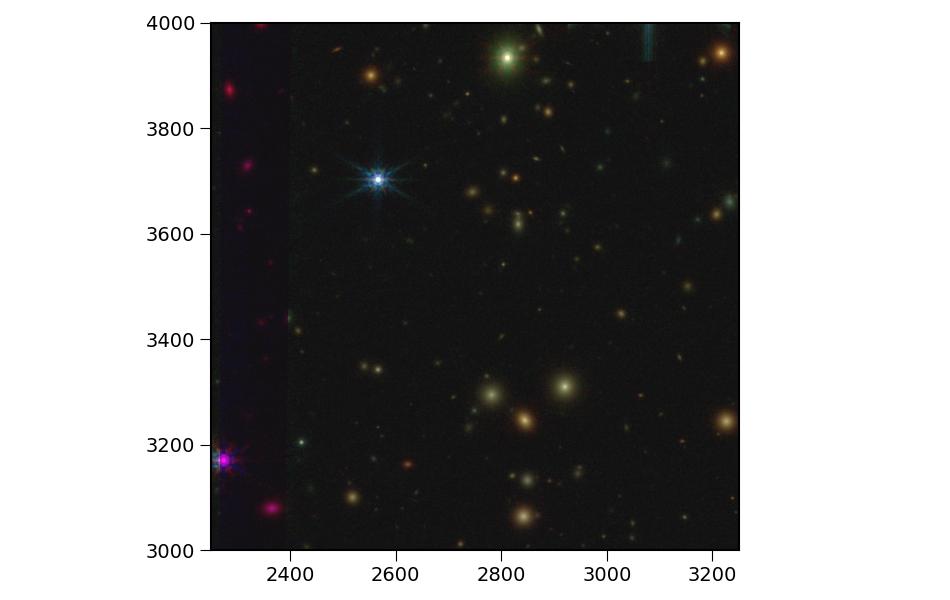

In [11]:
# Color image with 3 filters

b = scaled_images['F115W']
g = scaled_images['F200W']
r = scaled_images['F444W']

imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
plt.imshow(imrgb, origin='lower', extent=my_stamp_extent) # (xlo,xhi,ylo,yhi))
#matplotlib.image.imsave('stamp3.png', imrgb)

<IPython.core.display.Javascript object>


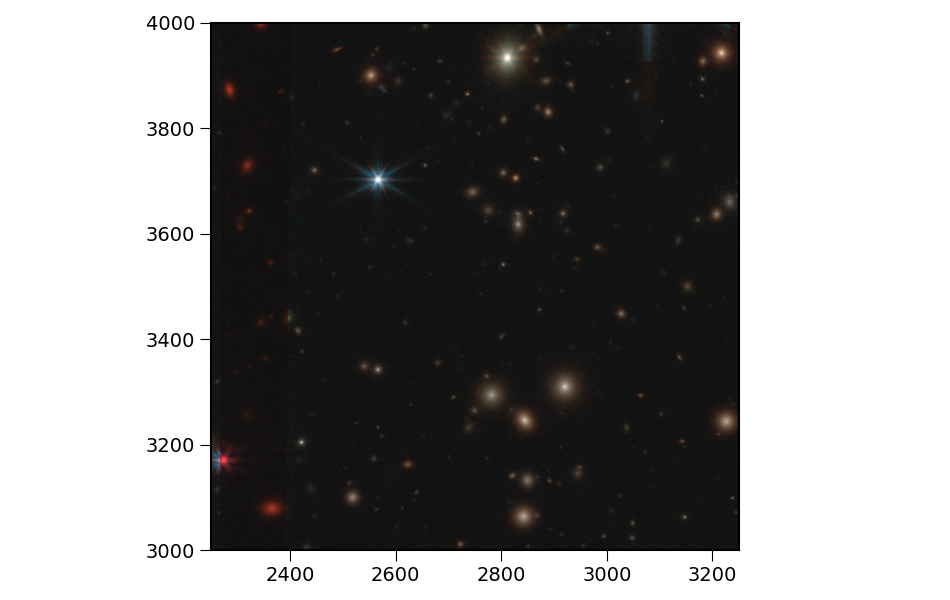

In [12]:
# Let's try a more complicated combination

b = scaled_images['F115W'] * (1/4.) + scaled_images['F150W'] * (2/4.) + scaled_images['F200W'] * (1/4.)
g = scaled_images['F150W'] * (1/4.) + scaled_images['F200W'] * (2/4.) + scaled_images['F277W'] * (1/4.)
r = scaled_images['F277W'] * (1/4.) + scaled_images['F356W'] * (2/4.) + scaled_images['F444W'] * (1/4.) 

imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
plt.imshow(imrgb, origin='lower', extent=my_stamp_extent) # (xlo,xhi,ylo,yhi))
matplotlib.image.imsave('stamp6.png', imrgb)

In [ ]:
if 0:
    # Lupton color image
    color_image = make_lupton_rgb(r, g, b, Q=10, stretch=0.07)  # , minimum=(0.25, 0.11, 0.12))
    fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
    plt.imshow(color_image, origin='lower')

## Once you're happy with the color image stamp,
# Create and save the color full image

In [13]:
scaled_images = {}
for i, filt in enumerate(filters):
    levels = levels_all[filt]
    print(filt, levels)
    data = fits.open(image_files_list[i])[idata].data
    scaled = imscale2(data, levels, noiselum)
    scaled_images[filt] = scaled

F115W (-0.01619422680232674, 0.009886023006401956, 6.58139)
F150W (-0.012821109557989985, 0.007612404355313629, 3.2255602)
F200W (-0.010242762975394726, 0.006759290583431721, 4.7715178)
F277W (-0.005981612077448517, 0.004122028301935643, 6.7338753)
F356W (-0.005328606115654111, 0.0037300470285117626, 6.995496)
F444W (-0.008522377698682249, 0.005674709682352841, 7.6220264)


In [14]:
b = scaled_images['F115W'] * (1/4.) + scaled_images['F150W'] * (2/4.) + scaled_images['F200W'] * (1/4.)
g = scaled_images['F150W'] * (1/4.) + scaled_images['F200W'] * (2/4.) + scaled_images['F277W'] * (1/4.)
r = scaled_images['F277W'] * (1/4.) + scaled_images['F356W'] * (2/4.) + scaled_images['F444W'] * (1/4.) 

imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)

In [15]:
outfile = field + '_color.png'
out_ext = ''
if out_ext:
    outfile = outfile.replace('.png', '_'+out_ext+'.png')
    
if os.path.exists(outfile):
    print(outfile, 'EXISTS')
else:
    print('SAVING', outfile)
    matplotlib.image.imsave(outfile, imrgb)

ceers5_color.png EXISTS
